# Preprocess WaPOR Precipitation data using python

## 1. Clipping to Region of Interest
### Example
To clip raster mapset to a region of interest, a shapefile or the extent coordinate of the ROI is needed.
For example, a shapefile of Awash Basin has been prepared. The code below shows how to get the exent of Awash Basin.

In [1]:
import shapefile
tg_shp= r"E:\Exercise\Awash\Awash_shapefile\Awash_shapefile.shp"
shape = shapefile.Reader(tg_shp)
shape.bbox

[37.95883206252312, 7.89534, 43.32093, 12.3873979377346]

In [2]:
extent=shape.bbox
xmin,ymin,xmax,ymax=extent[0],extent[1],extent[2],extent[3]

To get a list of all raster handlers in the folder to be clipped, we can use package *glob* as following.

In [3]:
import glob
input_folder=r'E:\WaPOR\L1_PCP_E'
input_fhs=glob.glob(input_folder+'\*.tif')
print('Number of files: {0}'.format(len(input_fhs)))

Number of files: 3813


The GDAL excutables *gdal_translate* can be used to quickly clip a raster file to a given extent. The excuteable can be called in command prompt console when its path is added to the environment variables (installment instruction).
Below is an example to clip a raster file in the obtained list of raster handlers. First, the input and output file handlers are defined. Then, using *subprocess* package to run command line with *gdal_translate* in python console. 

In [4]:
import os
output_folder=r'E:\Exercise\1.4\Clipped'
in_fh=input_fhs[0]
print('in_fh: '+in_fh)
out_fh=os.path.join(output_folder,os.path.split(in_fh)[-1])

import subprocess
string='gdal_translate -of GTiff -ot Float32 -projwin {0} {1} {2} {3} {4} {5}'.format(xmin,ymax,xmax,ymin,in_fh,out_fh)
proc = subprocess.Popen(string, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
out, err = proc.communicate()
print(out,err)
print('out_fh: '+out_fh)

in_fh: E:\WaPOR\L1_PCP_E\L1_PCP_090101.tif
('Input file size is 1902, 1602\r\n0...10...20...30...40...50...60...70...80...90...100 - done.\r\n', '')
out_fh: E:\Exercise\1.4\Clipped\L1_PCP_090101.tif


### Exercise (+)
Clip all the downloaded L1_PCP_E raster data (continent extent) to the extent of Awash Basin.

**Hint**: 

You can use a for-loop

**for** file **in** list_of_files:
    do something with file    

In [ ]:
#%% Write your code here

In [ ]:
for in_fh in input_fhs:
    out_fh=os.path.join(output_folder,os.path.split(in_fh)[-1])
    string='gdal_translate -of GTiff -ot Float32 -projwin {0} {1} {2} {3} {4} {5}'.format(xmin,ymax,xmax,ymin,in_fh,out_fh)
    proc = subprocess.Popen(string, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out, err = proc.communicate()
    print(out,err,out_fh)

## 2. Rescaling using metadata
### Example
The metadata of a dataset contains information about the data such as what is measured, in which unit it is measured, and what is stored in the value. Very often, data is stored in integer *int* format to reduce memory storage space. Thus, to analyze the data as if it is physical values, the stored value must be rescaled, in other words, multiplied with a conversion factor or *multiplier*. For example, the code below is used to get the multiplier of WaPOR Precipitation dataset **L1_PCP_E** and Net Primary Production dataset *L1_NPP_D*. Notice that the multiplier can be different for different dataset.

In [5]:
import hkvwaporpy as hkv
df=hkv.read_wapor.get_catalogus()

ds_code='L2_NPP_D' 
cube_info=hkv.read_wapor.get_info_cube(cube_code=ds_code)
multiplier = cube_info.loc['measures',ds_code].loc['multiplier'].iloc[0]
print(ds_code+' multiplier: {0}'.format(multiplier))

ds_code='L2_AETI_D' 
cube_info=hkv.read_wapor.get_info_cube(cube_code=ds_code)
multiplier = cube_info.loc['measures',ds_code].loc['multiplier'].iloc[0]
print(ds_code+' multiplier: {0}'.format(multiplier))

L2_NPP_D multiplier: 0.001
L2_AETI_D multiplier: 0.1


To multiply the raw data with a multiplier, you can open the mapset as a numerical array and do calculation with this array. The *gdal* package contains functions to work with raster mapset that can be used to do this task. A raster file has many properties including size, nodata value, transform, spatial reference, projection, etc. These information are stored in the dataset and can be read with *gdal* package. Below is the code to get these information from a GeoTIFF file. 

In [6]:
input_folder=r'E:\WaPOR\L2_AETI_D'
input_fhs=glob.glob(input_folder+'\*.tif')

in_fh=input_fhs[0]
print(in_fh)

from osgeo import gdal
from osgeo import gdal
DataSet = gdal.Open(in_fh, gdal.GA_ReadOnly)

import osr
Type = DataSet.GetDriver().ShortName
bandnumber=1
Subdataset = DataSet.GetRasterBand(bandnumber)
NDV = Subdataset.GetNoDataValue()
xsize = DataSet.RasterXSize
ysize = DataSet.RasterYSize
GeoT = DataSet.GetGeoTransform()
Projection = osr.SpatialReference()
Projection.ImportFromWkt(DataSet.GetProjectionRef())
driver = gdal.GetDriverByName(Type)

print('driver: {0} \nNDV: {1}\nxsize: {2}\nysize: {3}\nGeoT: {4}\nProjection: {5}'.format(
    driver, NDV, xsize, ysize, GeoT, Projection))

E:\WaPOR\L2_AETI_D\L2_AETI_0901.tif
driver: <osgeo.gdal.Driver; proxy of <Swig Object of type 'GDALDriverShadow *' at 0x0000000009873900> > 
NDV: -9999.0
xsize: 5406
ysize: 4529
GeoT: (37.957837282836, 0.000992063492, 0.0, 12.3883928732, 0.0, -0.000992063492)
Projection: GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0],
    UNIT["degree",0.0174532925199433],
    AUTHORITY["EPSG","4326"]]


The data in *gdal* dataset can be read using *ReadAsArray* function. For example, the below code is used to read the opened GeoTIFF dataset as a numpy array. 
You can plot the data in this array using function in *matplotlib* library. Look at the example code and the output plot below. Notice where high EvapoTranspiration occurs. Keep in mind that this is the raw data which show the average daily AETI in a dekad. Thus, the value in the color bar will be corrected with a multiplier and number of days in the next step.

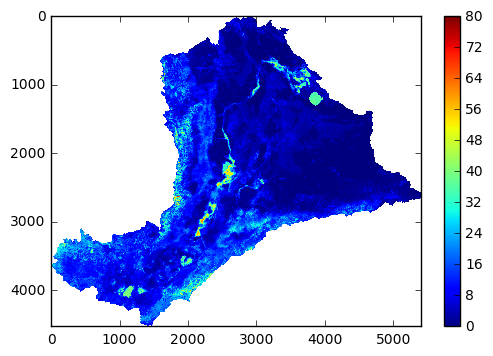

In [7]:
import numpy as np
Array = Subdataset.ReadAsArray().astype(np.float32)
Array[Array == NDV] = np.nan

from matplotlib import pyplot as plt
plt.imshow(Array)
plt.colorbar()
plt.show()

Normally, a dekad has 10 days except for the last dekad of the month. For example, the last dekad of February can have 8 or 9 days, and the last dekad of January has 11 days. The number of days in the raster period can be calculated when the starting and ending date is known. Recall that in the previous exercise, we can get this information using hkvwaporpy package's function *get_data_availaility*. Below you can see that each raster_id has a starting and ending day.

In [8]:
df_avail=hkv.read_wapor.get_data_availability(cube_info=cube_info,time_range='[2008-01-01,2018-12-31]')
df_avail

data_avail_period: DEKAD


,start_dekad,end_dekad,raster_id,bbox_srid,bbox_value
year,,,,,
2009,0101,0110,L2_AETI_0901,EPSG:4326,"[-17.6800595, -26.9816468, 54.5500992, 38.3308..."
2009,0111,0120,L2_AETI_0902,EPSG:4326,"[-17.6800595, -26.9816468, 54.5500992, 38.3308..."
2009,0121,0131,L2_AETI_0903,EPSG:4326,"[-17.6800595, -26.9816468, 54.5500992, 38.3308..."
2009,0201,0210,L2_AETI_0904,EPSG:4326,"[-17.6800595, -26.9816468, 54.5500992, 38.3308..."
2009,0211,0220,L2_AETI_0905,EPSG:4326,"[-17.6800595, -26.9816468, 54.5500992, 38.3308..."
2009,0221,0228,L2_AETI_0906,EPSG:4326,"[-17.6800595, -26.9816468, 54.5500992, 38.3308..."
2009,0301,0310,L2_AETI_0907,EPSG:4326,"[-17.6800595, -26.9816468, 54.5500992, 38.3308..."
2009,0311,0320,L2_AETI_0908,EPSG:4326,"[-17.6800595, -26.9816468, 54.5500992, 38.3308..."
2009,0321,0331,L2_AETI_0909,EPSG:4326,"[-17.6800595, -26.9816468, 54.5500992, 38.3308..."


We can access this information and use it to calculate the number of days in the raster period. Below is the example of how to get the number of days in the first raster period in the available data list *df_avail*. You can try to modify the code to do the same calculation for other raster periods.

In [9]:
raster_id=os.path.split(in_fh)[-1].split('.')[0]
print(raster_id)
raster_info=df_avail.loc[df_avail['raster_id']==raster_id]
raster_info

L2_AETI_0901


,start_dekad,end_dekad,raster_id,bbox_srid,bbox_value
year,,,,,
2009,0101,0110,L2_AETI_0901,EPSG:4326,"[-17.6800595, -26.9816468, 54.5500992, 38.3308..."


In [10]:
start=int(raster_info['start_dekad'].iloc[0])
end=int(raster_info['end_dekad'].iloc[0])
ndays=end-start+1
ndays

10

Once, we have the information of conversion factor *multiplier* and number of days *ndays*, we can correct the raw data in raster mapset by multiplying the opened array with these two values. See example below.

multiplier: 0.1
number of days: 10


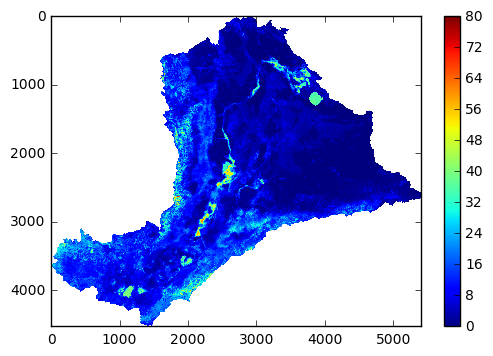

In [11]:
print('multiplier: {0}'.format(multiplier))
print('number of days: {0}'.format(ndays))
CorrectedArray=Array*multiplier*ndays
plt.imshow(CorrectedArray)
plt.colorbar()
plt.show()

To save our result as a raster file (GeoTIFF), we need to know the properties of the original raster file (driver, Nodata Value, size, extent, projection). Below is the example to save the above corrected array as a new raster file.

In [12]:
output_folder=r'E:\Exercise\1.4\Corrected\L2_AETI_D'
out_fh=os.path.join(output_folder,raster_id+'.tif')

datatypes = {"uint8": 1, "int8": 1, "uint16": 2, "int16": 3, "Int16": 3, "uint32": 4,
"int32": 5, "float32": 6, "float64": 7, "complex64": 10, "complex128": 11,
"Int32": 5, "Float32": 6, "Float64": 7, "Complex64": 10, "Complex128": 11,}
    
driver, NDV, xsize, ysize, GeoT, Projection
DataSet = driver.Create(out_fh,xsize,ysize,1,datatypes['float32'])
DataSet.GetRasterBand(1).SetNoDataValue(NDV)
DataSet.SetGeoTransform(GeoT)
DataSet.SetProjection(Projection.ExportToWkt())
DataSet.GetRasterBand(1).WriteArray(Array)
print(out_fh)

E:\Exercise\1.4\Corrected\L2_AETI_D\L2_AETI_0901.tif


### Exercise (++)
Correct all AETI, E, T, I data downloaded from Day 1 exercise. 

**Hint**: Make use of the functions in the examples. You can use a for-loop.

**Tips**: You can make your own function with *def* to re-use later 

**def** Function(Inputs):

    Do something with Inputs
    
    return Output

In [ ]:
#%% Write your code here

In [ ]:
import hkvwaporpy as hkv
import glob
import os
from osgeo import gdal
import numpy as np
import osr

def GetRasterInfo(in_fh):
    DataSet = gdal.Open(in_fh, gdal.GA_ReadOnly)
    Type = DataSet.GetDriver().ShortName
    bandnumber=1
    Subdataset = DataSet.GetRasterBand(bandnumber)
    NDV = Subdataset.GetNoDataValue()
    xsize = DataSet.RasterXSize
    ysize = DataSet.RasterYSize
    GeoT = DataSet.GetGeoTransform()
    Projection = osr.SpatialReference()
    Projection.ImportFromWkt(DataSet.GetProjectionRef())
    driver = gdal.GetDriverByName(Type)
    return NDV,xsize,ysize,GeoT,Projection,driver

def OpenRasterAsArray(in_fh,nan_value=True,bandnumber=1,dtype='float32'):  
    SourceDataSet = gdal.Open(in_fh, gdal.GA_ReadOnly)    
    Subdataset = SourceDataSet.GetRasterBand(bandnumber)
    NDV = Subdataset.GetNoDataValue()
    Array = Subdataset.ReadAsArray().astype(dtype)
    if nan_value:
        Array[Array == NDV] = np.nan
    return Array

def SaveArrayAsRaster(Array,out_fh,NDV,xsize,ysize,GeoT,Projection,driver,dtype='float32'):
    datatypes = {"uint8": 1, "int8": 1, "uint16": 2, "int16": 3, "Int16": 3, "uint32": 4,
    "int32": 5, "float32": 6, "float64": 7, "complex64": 10, "complex128": 11,
    "Int32": 5, "Float32": 6, "Float64": 7, "Complex64": 10, "Complex128": 11,}
    DataSet = driver.Create(out_fh,xsize,ysize,1,datatypes[dtype])
    if NDV is None:
        NDV=-9999
    DataSet.GetRasterBand(1).SetNoDataValue(NDV)
    DataSet.SetGeoTransform(GeoT)
    DataSet.SetProjection(Projection.ExportToWkt())
    DataSet.GetRasterBand(1).WriteArray(Array)
    return out_fh

df=hkv.read_wapor.get_catalogus()
ds_code='L2_AETI_D' 
cube_info=hkv.read_wapor.get_info_cube(cube_code=ds_code)
df_avail=hkv.read_wapor.get_data_availability(cube_info=cube_info,time_range='[2008-01-01,2018-12-31]')

### Get multiplier
multiplier = cube_info.loc['measures',ds_code].loc['multiplier'].iloc[0]

### Get input rasters
input_folder=r'E:\WaPOR\L2_AETI_D'
input_fhs=glob.glob(input_folder+'\*.tif')

output_folder=r'E:\Exercise\1.4\Corrected\L2_AETI_D'
### Get GeoInfo
in_fh=input_fhs[0]
NDV,xsize,ysize,GeoT,Projection,driver=GetRasterInfo(in_fh)

### Calculation
for in_fh in input_fhs:
    ### Get number of days in raster period
    raster_id=os.path.split(in_fh)[-1].split('.')[0]
    raster_info=df_avail.loc[df_avail['raster_id']==raster_id]
    start=int(raster_info['start_dekad'].iloc[0])
    end=int(raster_info['end_dekad'].iloc[0])
    ndays=end-start+1
    ### Correct raster data with multiplier and number of days
    Array=OpenRasterAsArray(in_fh)
    CorrectedArray=Array*multiplier*ndays
    ### Save corrected array
    out_fh=os.path.join(output_folder,raster_id+'.tif')
    SaveArrayAsRaster(CorrectedArray,out_fh,NDV,xsize,ysize,GeoT,Projection,driver) 
    print(out_fh)

In [17]:
ds_codes=['L2_E_D','L2_I_D','L2_T_D']
for ds_code in ds_codes:
    cube_info=hkv.read_wapor.get_info_cube(cube_code=ds_code)
    df_avail=hkv.read_wapor.get_data_availability(cube_info=cube_info,time_range='[2008-01-01,2018-12-31]')

    ### Get multiplier
    multiplier = cube_info.loc['measures',ds_code].loc['multiplier'].iloc[0]

    ### Get input rasters
    input_folder=os.path.join(r'E:\WaPOR',ds_code)
    input_fhs=glob.glob(input_folder+'\*.tif')

    output_folder=os.path.join(r'E:\Exercise\1.4\Corrected',ds_code)
    ### Get GeoInfo
    in_fh=input_fhs[0]
    NDV,xsize,ysize,GeoT,Projection,driver=GetRasterInfo(in_fh)

    ### Calculation
    for in_fh in input_fhs:
        ### Get number of days in raster period
        raster_id=os.path.split(in_fh)[-1].split('.')[0]
        raster_info=df_avail.loc[df_avail['raster_id']==raster_id]
        start=int(raster_info['start_dekad'].iloc[0])
        end=int(raster_info['end_dekad'].iloc[0])
        ndays=end-start+1
        ### Correct raster data with multiplier and number of days
        Array=OpenRasterAsArray(in_fh)
        CorrectedArray=Array*multiplier*ndays
        ### Save corrected array
        out_fh=os.path.join(output_folder,raster_id+'.tif')
        SaveArrayAsRaster(CorrectedArray,out_fh,NDV,xsize,ysize,GeoT,Projection,driver) 
        print(out_fh)

data_avail_period: DEKAD
E:\Exercise\1.4\Corrected\L2_E_D\L2_E_0901.tif
E:\Exercise\1.4\Corrected\L2_E_D\L2_E_0902.tif
E:\Exercise\1.4\Corrected\L2_E_D\L2_E_0903.tif
E:\Exercise\1.4\Corrected\L2_E_D\L2_E_0904.tif
E:\Exercise\1.4\Corrected\L2_E_D\L2_E_0905.tif
E:\Exercise\1.4\Corrected\L2_E_D\L2_E_0906.tif
E:\Exercise\1.4\Corrected\L2_E_D\L2_E_0907.tif
E:\Exercise\1.4\Corrected\L2_E_D\L2_E_0908.tif
E:\Exercise\1.4\Corrected\L2_E_D\L2_E_0909.tif
E:\Exercise\1.4\Corrected\L2_E_D\L2_E_0910.tif
E:\Exercise\1.4\Corrected\L2_E_D\L2_E_0911.tif
E:\Exercise\1.4\Corrected\L2_E_D\L2_E_0912.tif
E:\Exercise\1.4\Corrected\L2_E_D\L2_E_0913.tif
E:\Exercise\1.4\Corrected\L2_E_D\L2_E_0914.tif
E:\Exercise\1.4\Corrected\L2_E_D\L2_E_0915.tif
E:\Exercise\1.4\Corrected\L2_E_D\L2_E_0916.tif
E:\Exercise\1.4\Corrected\L2_E_D\L2_E_0917.tif
E:\Exercise\1.4\Corrected\L2_E_D\L2_E_0918.tif
E:\Exercise\1.4\Corrected\L2_E_D\L2_E_0919.tif
E:\Exercise\1.4\Corrected\L2_E_D\L2_E_0920.tif
E:\Exercise\1.4\Corrected\L2_E_D\L2

IndexError: single positional indexer is out-of-bounds

## 3. Convert to Monthly data
### Example
To convert dekadal or daily data to monthly data, we will sum all the data in dekadal raster maps in the month. 
First, we will get a list of all the month and years of the data we have. For example, below is the code to get a list of month and year need to be calculated.

In [13]:
import pandas as pd
start_date='2009-01-01'
end_date='2009-12-31'
month_dates=pd.date_range(start_date,end_date,freq='M')
for date in month_dates:
    print(date.year,date.month)

(2009, 1)
(2009, 2)
(2009, 3)
(2009, 4)
(2009, 5)
(2009, 6)
(2009, 7)
(2009, 8)
(2009, 9)
(2009, 10)
(2009, 11)
(2009, 12)


Now, when we look at the list of dekadal data we have. The *raster_id* was used to name the raster file in the previous exercise. This *raster_id* only contains the year and the dekad index (from 1 to 36). 

In [ ]:
input_folder=r'E:\Exercise\1.4\Corrected\L2_AETI_D'
input_fhs=glob.glob(input_folder+'\*.tif')

ds_code='L2_AETI_D' 
cube_info=hkv.read_wapor.get_info_cube(cube_code=ds_code)
df_avail=hkv.read_wapor.get_data_availability(cube_info=cube_info,time_range='[2008-01-01,2018-12-31]')

for in_fh in input_fhs:
    print(in_fh)

Therefore, we will use this *raster_id* to get the month of the dekad from the *df_avail* dataframe. Remember from the previous exercise, we used the *start_dekad* and *end_dekad* to calculate the number of days in the dekad? We can also use this to check if the dekad index belong to the month we want to calculate total value using *if* condition.
For example, the month we want to calculate total value is the first month of the list (date = month_dates[0]). We loop over all raster files and check if the month and year it belongs to is same with the month and year we want to calculate.
**if** (year==date.year)&(month==date.month):
    month_fhs.append(in_fh)
If this is *True*, then the raster file handler will be added to the list of file handlers belong to the concerned month. 

In [ ]:
date=month_dates[0]
print(date)
month_fhs=[]
for in_fh in input_fhs:
    raster_id=os.path.split(in_fh)[-1].split('.')[0]
    raster_info=df_avail.loc[df_avail['raster_id']==raster_id]
    start=raster_info['start_dekad'].iloc[0]
    year=raster_info.index.values.astype(int)[0]
    month=int(start[0:2])
    if (year==date.year)&(month==date.month):
        month_fhs.append(in_fh)
print(month_fhs)

To add up data from the 3 rasters, we create a zeros 2D array of the same size with the 3 rasters using *np.zeros*. Then read each raster as array and add the value to this zeros array. Below is an example to calculate the SumArray

In [ ]:
NDV,xsize,ysize,GeoT,Projection,driver=GetRasterInfo(input_fhs[0])
print(xsize,ysize)
SumArray=np.zeros((ysize,xsize))
for fh in month_fhs:
    Array=OpenRasterAsArray(fh)
    SumArray+=Array
plt.imshow(SumArray)
plt.colorbar()
plt.show()

In [ ]:
output_folder=r'E:\Exercise\1.4\Monthly\L2_AETI_M'
out_fh=os.path.join(output_folder,'AETI_{:04d}{:02d}.tif'.format(date.year,date.month))
SaveArrayAsRaster(SumArray,out_fh,NDV,xsize,ysize,GeoT,Projection,driver,dtype='float32')

In [ ]:
for date in month_dates:
    month_fhs=[]
    for in_fh in input_fhs:
        raster_id=os.path.split(in_fh)[-1].split('.')[0]
        raster_info=df_avail.loc[df_avail['raster_id']==raster_id]
        start=raster_info['start_dekad'].iloc[0]
        year=raster_info.index.values.astype(int)[0]
        month=int(start[0:2])
        if (year==date.year)&(month==date.month):
            month_fhs.append(in_fh)
    SumArray=np.zeros((ysize,xsize))
    for fh in month_fhs:
        Array=OpenRasterAsArray(fh)
        SumArray+=Array
    out_fh=os.path.join(output_folder,'AETI_{:04d}{:02d}.tif'.format(date.year,date.month))
    SaveArrayAsRaster(SumArray,out_fh,NDV,xsize,ysize,GeoT,Projection,driver,dtype='float32')

### Exercise (++) 
Convert Level 1 Daily Precipitation data to monthly data of Awash Basin

Convert Level 2 Dekadal AETI, Evaporation, Transpiration, and Interception to monthly data for a chosen year

In [ ]:
#%% Write your code here

In [ ]:
ds_code='L1_PCP_E' 
cube_info=hkv.read_wapor.get_info_cube(cube_code=ds_code)
df_avail=hkv.read_wapor.get_data_availability(cube_info=cube_info,time_range='[2008-01-01,2019-12-31]')
multiplier = cube_info.loc['measures',ds_code].loc['multiplier'].iloc[0]
print(ds_code+' multiplier: {0}'.format(multiplier))

input_folder=r'E:\Exercise\1.4\Clipped'
output_folder=r'E:\Exercise\1.4\Monthly\L1_PCP_M'
input_fhs=glob.glob(os.path.join(input_folder,'*.tif'))
NDV,xsize,ysize,GeoT,Projection,driver=GetRasterInfo(input_fhs[0])

start_date='2009-01-01'
end_date='2018-12-31'
month_dates=pd.date_range(start_date,end_date,freq='M')

for date in month_dates:
    month_fhs=[]
    for in_fh in input_fhs:
        raster_id=os.path.split(in_fh)[-1].split('.')[0]
        raster_info=df_avail.loc[df_avail['raster_id']==raster_id]
        raster_date=raster_info['date'].iloc[0]
        year=raster_date.year
        month=raster_date.month
        if (year==date.year)&(month==date.month):
            month_fhs.append(in_fh)
    SumArray=np.zeros((ysize,xsize))
    for fh in month_fhs:
        Array=OpenRasterAsArray(fh)
        SumArray+=Array*multiplier
    out_fh=os.path.join(output_folder,'PCP_{:04d}{:02d}.tif'.format(date.year,date.month))
    SaveArrayAsRaster(SumArray,out_fh,NDV,xsize,ysize,GeoT,Projection,driver,dtype='float32')

In [16]:
input_folder=r'E:\Exercise\1.4\Corrected\L2_E_D'
input_fhs=glob.glob(input_folder+'\*.tif')
output_folder=r'E:\Exercise\1.4\Monthly\L2_E_M'

ds_code='L2_E_D' 
cube_info=hkv.read_wapor.get_info_cube(cube_code=ds_code)
df_avail=hkv.read_wapor.get_data_availability(cube_info=cube_info,time_range='[2008-01-01,2018-12-31]')


import pandas as pd
start_date='2009-01-01'
end_date='2009-12-31'
month_dates=pd.date_range(start_date,end_date,freq='M')
for date in month_dates:
    month_fhs=[]
    for in_fh in input_fhs:
        raster_id=os.path.split(in_fh)[-1].split('.')[0]
        raster_info=df_avail.loc[df_avail['raster_id']==raster_id]
        start=raster_info['start_dekad'].iloc[0]
        year=raster_info.index.values.astype(int)[0]
        month=int(start[0:2])
        if (year==date.year)&(month==date.month):
            month_fhs.append(in_fh)
    SumArray=np.zeros((ysize,xsize))
    for fh in month_fhs:
        Array=OpenRasterAsArray(fh)
        SumArray+=Array
    out_fh=os.path.join(output_folder,'E_{:04d}{:02d}.tif'.format(date.year,date.month))
    SaveArrayAsRaster(SumArray,out_fh,NDV,xsize,ysize,GeoT,Projection,driver,dtype='float32')

data_avail_period: DEKAD


AttributeError: 'NoneType' object has no attribute 'GetRasterBand'